# OSMnx features demo

Author: [Geoff Boeing](https://geoffboeing.com/)

Get street networks and other spatial data anywhere in the world from OpenStreetMap then analyze and visualize them.

More info:

  - [Overview of OSMnx](http://geoffboeing.com/2016/11/osmnx-python-street-networks/)
  - [Documentation and install instructions](https://osmnx.readthedocs.io)
  - [Examples, demos, tutorials](https://github.com/gboeing/osmnx-examples)
  - [Journal article and citation info](http://geoffboeing.com/publications/osmnx-complex-street-networks/)
  - [GitHub repo](https://github.com/gboeing/osmnx)
  
This notebook provides a quick tour of some of OSMnx's key features including how to:

  - download/model street networks
  - calculate stats
  - visualize centrality
  - impute speeds/travel times and calculate shortest paths
  - attach and visualize elevation data and edge grades
  - download/model other infrastructure types
  - download points of interest data

In [2]:
import networkx as nx
import osmnx as ox

ox.__version__

'1.8.1'

## Working with street networks

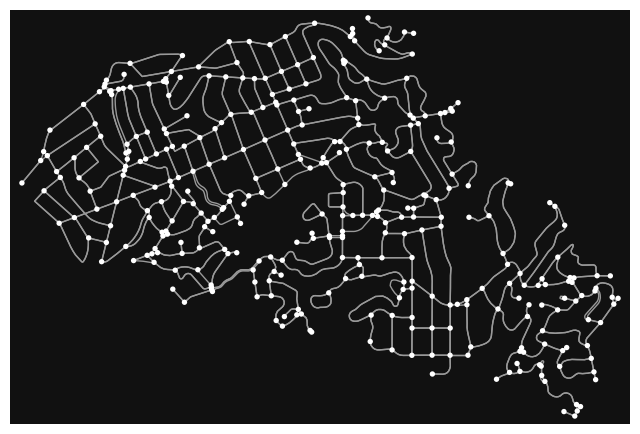

In [2]:
# download/model a street network for some city then visualize it
G = ox.graph_from_place("Piedmont, California, USA", network_type="drive")
fig, ax = ox.plot_graph(G)

OSMnx geocodes the query "Piedmont, California, USA" to retrieve the place boundaries of that city from the Nominatim API, retrieves the drivable street network data within those boundaries from the Overpass API, constructs a graph model, then simplifies/corrects its topology such that nodes represent intersections and dead-ends and edges represent the street segments linking them. All of this is discussed in detail in the documentation and these examples.

OSMnx models all networks as NetworkX `MultiDiGraph` objects. You can convert to:
  - undirected MultiGraphs
  - DiGraphs without (possible) parallel edges
  - GeoPandas node/edge GeoDataFrames

In [3]:
# convert your MultiDiGraph to an undirected MultiGraph
M = ox.utils_graph.get_undirected(G)

# convert your MultiDiGraph to a DiGraph without parallel edges
D = ox.utils_graph.get_digraph(G)

In [4]:
# you can convert your graph to node and edge GeoPandas GeoDataFrames
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
gdf_nodes.head()

,y,x,street_count,highway,geometry
osmid,,,,,
53017091,37.826250,-122.247604,3,NaN,POINT (-122.24760 37.82625)
53018397,37.824224,-122.247194,3,NaN,POINT (-122.24719 37.82422)
53018399,37.824900,-122.246113,3,NaN,POINT (-122.24611 37.82490)
53018402,37.825406,-122.245338,3,NaN,POINT (-122.24534 37.82541)
53018404,37.825948,-122.244467,3,NaN,POINT (-122.24447 37.82595)


In [5]:
gdf_edges.head()

osmid          name      highway  oneway reversed  \
u        v        key                                                          
53017091 53064327 0      6345781   Rose Avenue  residential   False    False   
         53075599 0      6345781   Rose Avenue  residential   False     True   
53018397 53018399 0      6327298   Lake Avenue  residential   False    False   
         53018411 0    196739937  Linda Avenue     tertiary   False    False   
         53097980 0    196739937  Linda Avenue     tertiary   False     True   

                        length  \
u        v        key            
53017091 53064327 0    230.124   
         53075599 0    122.235   
53018397 53018399 0    121.096   
         53018411 0     37.803   
         53097980 0     99.976   

                                                                geometry  \
u        v        key                                                      
53017091 53064327 0    LINESTRING (-122.24760 37.82625, -122.24750 37...   
         53075599 0    LINESTRING (-122.24760 37.82625, -122.24771 37...   
53018397 53018399 0    LINESTRING (-122.24719 37.82422, -122.24712 37...   
         53018411 0    LINESTRING (-122.24719 37.82422, -122.24713 37...   
         53097980 0    LINESTRING (-122.24719 37.82422, -122.24773 37...   

                      lanes maxspeed bridge junction  
u        v        key                                 
53017091 53064327 0     NaN      NaN    NaN      NaN  
         53075599 0     NaN      NaN    NaN      NaN  
53018397 53018399 0     NaN      NaN    NaN      NaN  
         53018411 0     NaN      NaN    NaN      NaN  
         53097980 0     NaN      NaN    NaN      NaN

You can create a graph from node/edge GeoDataFrames, as long as gdf_nodes is indexed by osmid and gdf_edges is multi-indexed by u, v, key (following normal MultiDiGraph structure). This allows you to load graph node/edge ShapeFiles or GeoPackage layers as GeoDataFrames then convert to a MultiDiGraph for graph analytics.

In [6]:
# convert node/edge GeoPandas GeoDataFrames to a NetworkX MultiDiGraph
G2 = ox.graph_from_gdfs(gdf_nodes, gdf_edges, graph_attrs=G.graph)

## Basic street network stats

In [7]:
# what sized area does our network cover in square meters?
G_proj = ox.project_graph(G)
nodes_proj = ox.graph_to_gdfs(G_proj, edges=False)
graph_area_m = nodes_proj.unary_union.convex_hull.area
graph_area_m

4199283.565369894

In [8]:
# show some basic stats about the network
ox.basic_stats(G_proj, area=graph_area_m, clean_int_tol=15)

{'n': 353,
 'm': 948,
 'k_avg': 5.371104815864022,
 'edge_length_total': 112028.81500000024,
 'edge_length_avg': 118.17385548523231,
 'streets_per_node_avg': 2.951841359773371,
 'streets_per_node_counts': {0: 0, 1: 34, 2: 0, 3: 270, 4: 47, 5: 2},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.09631728045325778,
  2: 0.0,
  3: 0.7648725212464589,
  4: 0.13314447592067988,
  5: 0.0056657223796034},
 'intersection_count': 319,
 'street_length_total': 58076.24899999998,
 'street_segment_count': 497,
 'street_length_avg': 116.85361971830982,
 'circuity_avg': 1.111160442821775,
 'self_loop_proportion': 0.006036217303822937,
 'clean_intersection_count': 267,
 'node_density_km': 84.06195830904933,
 'intersection_density_km': 75.96533909514656,
 'edge_density_km': 26678.078118816487,
 'street_density_km': 13830.037456611803,
 'clean_intersection_density_km': 63.58227441505997}

stats documentation: https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.stats

In [9]:
# save graph to disk as geopackage (for GIS) or graphml file (for gephi etc)
ox.save_graph_geopackage(G, filepath="./data/mynetwork.gpkg")
ox.save_graphml(G, filepath="./data/mynetwork.graphml")

## Visualize street centrality

Here we plot the street network and color its edges (streets) by their relative closeness centrality.

In [10]:
# convert graph to line graph so edges become nodes and vice versa
edge_centrality = nx.closeness_centrality(nx.line_graph(G))
nx.set_edge_attributes(G, edge_centrality, "edge_centrality")

In [27]:
edge_centrality

{(53017091, 53064327, 0): 0.05209175000862948,
 (53064327, 53075602, 0): 0.054768040163377586,
 (53064327, 53064328, 0): 0.054768040163377586,
 (53064327, 53017091, 0): 0.054768040163377586,
 (53017091, 53075599, 0): 0.05209175000862948,
 (53075599, 53017091, 0): 0.051846754780901186,
 (53075599, 53097976, 0): 0.05184962368056812,
 (53075599, 53097980, 0): 0.051846754780901186,
 (53018397, 53018399, 0): 0.05194735553582587,
 (53018399, 53018402, 0): 0.05352907164554282,
 (53018399, 53018397, 0): 0.05352907164554282,
 (53018399, 53078914, 0): 0.05352907164554282,
 (53018397, 53018411, 0): 0.05194735553582587,
 (53018411, 53018410, 0): 0.05361176331131864,
 (53018411, 53145241, 0): 0.05361176331131864,
 (53018411, 53018397, 0): 0.05361176331131864,
 (53018397, 53097980, 0): 0.05194735553582587,
 (53097980, 53064328, 0): 0.05420097172346293,
 (53097980, 53018397, 0): 0.05420097172346293,
 (53097980, 53075599, 0): 0.05420097172346293,
 (53018402, 53018399, 0): 0.05619348720571077,
 (530184

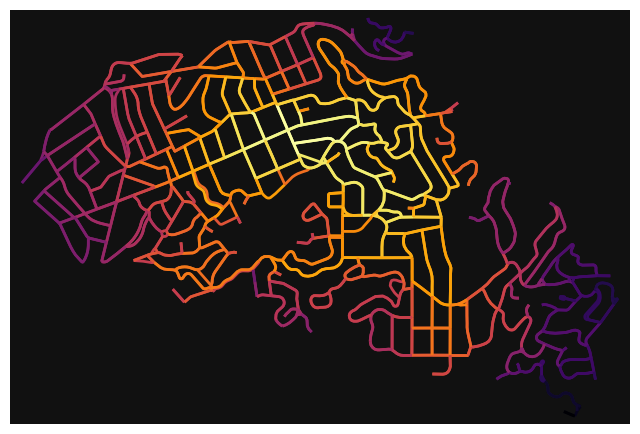

In [11]:
# color edges in original graph with closeness centralities from line graph
ec = ox.plot.get_edge_colors_by_attr(G, "edge_centrality", cmap="inferno")
fig, ax = ox.plot_graph(G, edge_color=ec, edge_linewidth=2, node_size=0)

## Routing

In [12]:
# impute missing edge speeds and calculate edge travel times with the speed module
G = ox.speed.add_edge_speeds(G)
G = ox.speed.add_edge_travel_times(G)

In [13]:
# get the nearest network nodes to two lat/lng points with the distance module
orig = ox.distance.nearest_nodes(G, X=-122.245846, Y=37.828903)
dest = ox.distance.nearest_nodes(G, X=-122.215006, Y=37.812303)

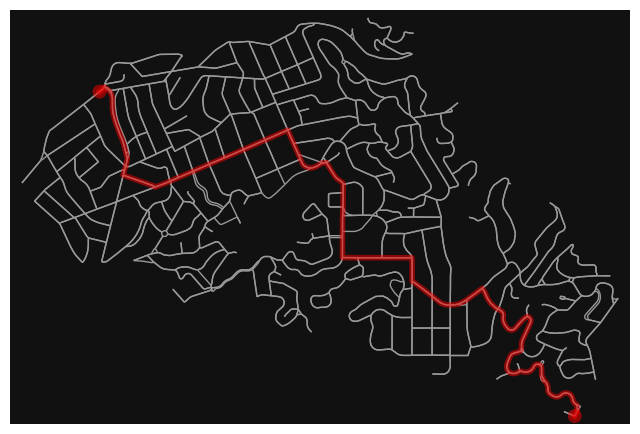

In [14]:
# find the shortest path between nodes, minimizing travel time, then plot it
route = ox.shortest_path(G, orig, dest, weight="travel_time")
fig, ax = ox.plot_graph_route(G, route, node_size=0)

In [15]:
# how long is our route in meters?
edge_lengths = ox.utils_graph.route_to_gdf(G, route)["length"]
round(sum(edge_lengths))

4761

In [16]:
# how far is it between these two nodes as the crow flies?
# use OSMnx's vectorized great-circle distance (haversine) function
orig_x = G.nodes[orig]["x"]
orig_y = G.nodes[orig]["y"]
dest_x = G.nodes[dest]["x"]
dest_y = G.nodes[dest]["y"]
round(ox.distance.great_circle(orig_y, orig_x, dest_y, dest_x))

3124

You can add elevation attributes to your graph's nodes automatically with the `elevation` module, using either local raster files or the Google Maps Elevation API.

In [17]:
# add elevation to nodes automatically, calculate edge grades, plot network
# you need a google elevation api key to run this cell!
try:
    from keys import google_elevation_api_key

    G = ox.elevation.add_node_elevations_google(G, api_key=google_elevation_api_key)
    G = ox.elevation.add_edge_grades(G)
    nc = ox.plot.get_node_colors_by_attr(G, "elevation", cmap="plasma")
    fig, ax = ox.plot_graph(G, node_color=nc, node_size=20, edge_linewidth=2, edge_color="#333")
except ImportError:
    print("You need a google_elevation_api_key to run this cell.")

You need a google_elevation_api_key to run this cell.


Nodes are colored from lowest elevation (dark blue) to highest (bright yellow).

Example: create [elevation-based](12-node-elevations-edge-grades.ipynb) impedance functions to route around hills.

## Get networks other ways

make queries less ambiguous to help the geocoder out, if it's not finding what you're looking for

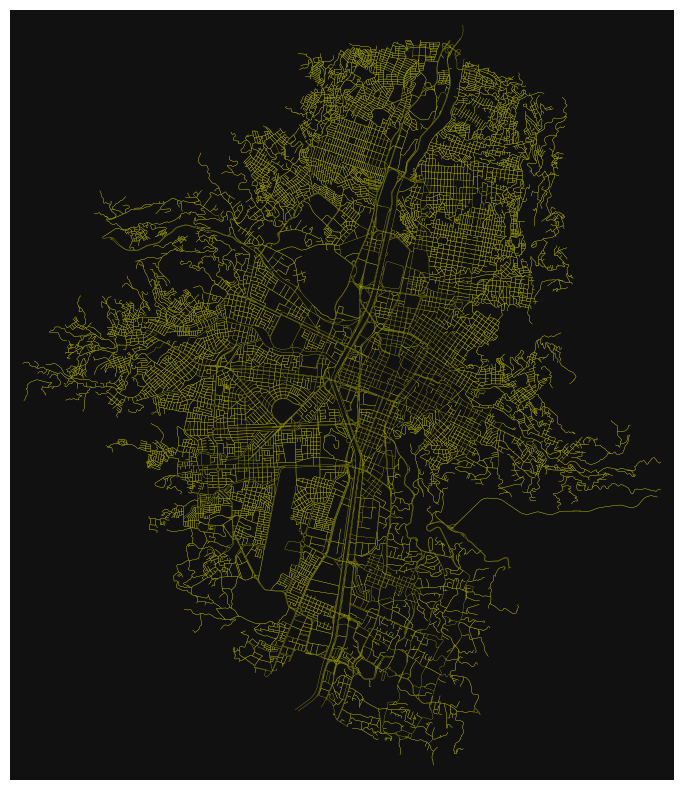

In [3]:
# you can make query an unambiguous dict to help the geocoder find it
place = {"city": "Medellin", "state": "Antioquia", "country": "Colombia"}
G = ox.graph_from_place(place, network_type="drive", truncate_by_edge=True)
fig, ax = ox.plot_graph(G, figsize=(10, 10), node_size=0, edge_color="y", edge_linewidth=0.2)

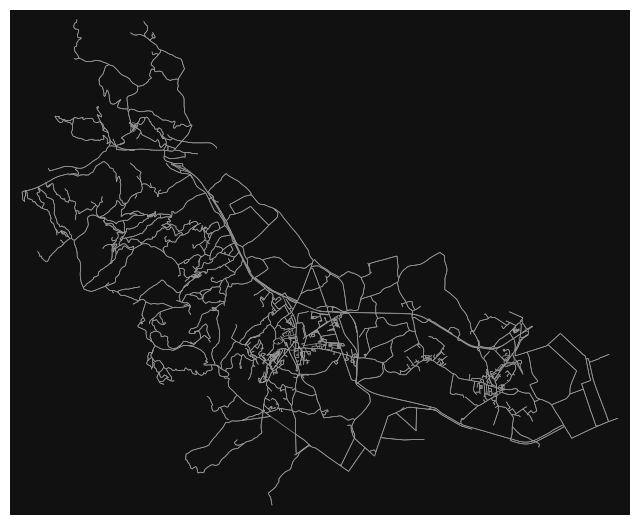

In [19]:
# you can get networks anywhere in the world
G = ox.graph_from_place("Sinalunga, Italy", network_type="all")
fig, ax = ox.plot_graph(G, node_size=0, edge_linewidth=0.5)

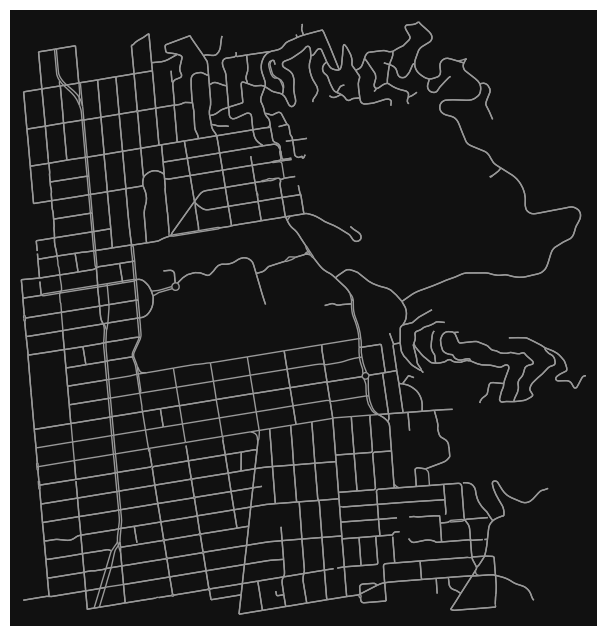

In [20]:
# or get network by address, coordinates, bounding box, or any custom polygon
# ...useful when OSM just doesn't already have a polygon for the place you want
wurster_hall = (37.870605, -122.254830)
one_mile = 1609  # meters
G = ox.graph_from_point(wurster_hall, dist=one_mile, network_type="drive")
fig, ax = ox.plot_graph(G, node_size=0)

Examples of [getting networks](01-overview-osmnx.ipynb) by coordinates, bounding box, or any custom polygon shape.

## Get other networked infrastructure types

...like rail or electric grids or even the canals of Venice and Amsterdam, using the `custom_filter` parameter: [see more examples](08-custom-filters-infrastructure.ipynb).

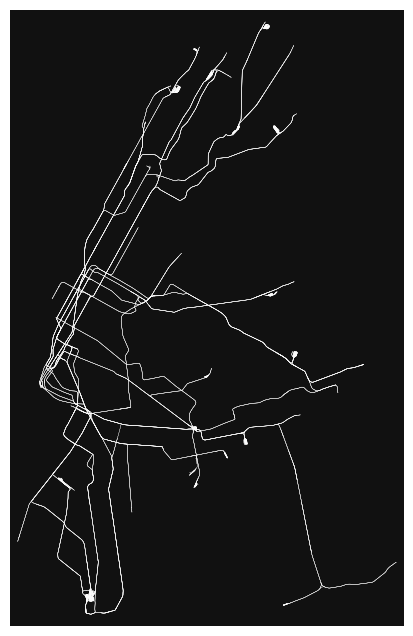

In [21]:
# get NY subway rail network
G = ox.graph_from_place(
    "New York, New York, USA",
    retain_all=False,
    truncate_by_edge=True,
    simplify=True,
    custom_filter='["railway"~"subway"]',
)

fig, ax = ox.plot_graph(G, node_size=0, edge_color="w", edge_linewidth=0.2)

## Get any geospatial features' geometries and attributes

Use the `features` module to download any OSM features, such as local amenities, points of interest, or building footprints, and turn them into a GeoDataFrame: [see docs](https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.features). For more usage examples of downloading geospatial features from OSM, see [this notebook](16-download-osm-geospatial-features.ipynb).

In [22]:
# get all building footprints in some neighborhood
place = "SoHo, New York, NY"
tags = {"building": True}
gdf = ox.features_from_place(place, tags)
gdf.shape

(847, 87)

d:\inteia_tool\.conda\Lib\site-packages\geopandas\geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
d:\inteia_tool\.conda\Lib\site-packages\pandas\core\frame.py:706: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
d:\inteia_tool\.conda\Lib\site-packages\pandas\core\frame.py:706: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
d:\inteia_tool\.conda\Lib\site-packages\geopandas\geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
d:\inteia_tool\.conda\Lib\site-packages\geopandas\geodataframe.py:1645: DeprecationW

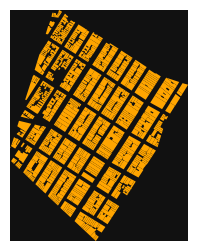

In [23]:
fig, ax = ox.plot_footprints(gdf, figsize=(3, 3))

See the other notebooks for more examples of visualization with OSMnx.

In [24]:
# get all parks and bus stops in some neighborhood
tags = {"leisure": "park", "highway": "bus_stop"}
gdf = ox.features_from_place(place, tags)
gdf.shape

d:\inteia_tool\.conda\Lib\site-packages\geopandas\geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
d:\inteia_tool\.conda\Lib\site-packages\pandas\core\frame.py:706: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
d:\inteia_tool\.conda\Lib\site-packages\pandas\core\frame.py:706: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
d:\inteia_tool\.conda\Lib\site-packages\geopandas\geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
d:\inteia_tool\.conda\Lib\site-packages\pandas\core\frame.py:706: DeprecationWarning

(21, 36)